# Application of Gaussian Process to SPDR S&P 500 ETF Trust (SPY) prediction

Author: Matheus Schossler

Date: January 29, 2023

**Gaussian process regression** (GPR) uses the kernel to define the covariance of a prior distribution over the target functions and uses the observed training data to define a likelihood function. Based on Bayes theorem, a (Gaussian) posterior distribution over target functions is defined, whose mean is used for prediction.

In this notebook we study the SPDR S&P 500 ETF Trust (SPY) data from [Yahoo Finance](https://finance.yahoo.com/quote/SPY/history/) over different time regimes and normalizations using GPR.

In [1]:
# Set Width of Notebook to 80% of screen
from IPython.display import display, HTML, Image
display(HTML("<style>.container { width:80% !important; }</style>"))

### Load packages

In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct
from sklearn.gaussian_process.kernels import ExpSineSquared, RationalQuadratic, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns

### Preeprocess data set 

In [3]:
raw_data = pd.read_csv('data/SPY_daily.csv') #source: https://finance.yahoo.com/quote/SPY/history/
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
close_weekly = raw_data.resample('W', on='Date').mean().reset_index()

close_weekly = close_weekly[close_weekly['Date']>'2010-08-01'].reset_index()
few_months = raw_data[raw_data['Date']>'2021-06-01'].reset_index()
day0data = few_months.loc[0:,'Close'].shift().tail(-1) 
day1data = few_months.loc[1:,'Close']
few_months['Close_Ratio'] = (1 - day1data / day0data) * 100

data_dic = {}
data1, data_name = close_weekly[['Date','Close']], 'weekly average'
data_dic[data_name]=data1
data2, data_name = few_months[['Date','Close']], 'close daily'
data_dic[data_name]=data2
data3, data_name = few_months[['Date','Close_Ratio']].tail(-1).reset_index(drop=True) , 'Daily Percentage Move'
data_dic[data_name]=data3

### Define the Gaussian Process Regressor model

In [4]:
def gaussian_process_regressor(x_train, y_train, x_test, y_test, kernel):
    "Defines GP regressor model with kernel"
    kernel = params['kernel']
    sigma_n = params['sigma_n']
    n_restarts_optimizer = params['n_restarts_optimizer']
    
    gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=n_restarts_optimizer)
    # Fitting in the gp model
    gp.fit(x_train.reshape(-1, 1), y_train)

    
    
    # Model making a prediction on test data
    x, y = np.concatenate((x_train,x_test)), np.concatenate((y_train,y_test))
    y_prediction_x, std_x = gp.predict(x.reshape(-1, 1), return_std = True)

    # Evaluation of mean_squared_error of the model against the test set
    y_prediction_x_test, std_x_test = gp.predict(x_test.reshape(-1, 1), return_std = True)
    print(f"MSE Of Test Set : {mean_squared_error(y_test, y_prediction_x_test)}")
    # Evaluation of r2 score of the model against the test set
    # print(f"r2 Score Of Test Set : {r2_score(y_test, y_prediction)}")

    params_fitted = gp.kernel_.get_params()
    display(params_fitted)

    # Generate samples from posterior distribution. 
    y_posterior_samples = gp.sample_y(x.reshape(-1, 1), n_samples=1)
#     # Compute the mean of the sample. 
    y_posterior = np.apply_over_axes(func=np.mean, a=y_posterior_samples, axes=1).squeeze()
#     # Compute the standard deviation of the sample. 
#     y_posterior_sd = np.apply_over_axes(func=np.std, a=y_posterior_samples, axes=1).squeeze()
#     std_vs_y_posterior_sd = 100*abs(std - y_posterior_sd)/std;
    return y_prediction_x, std_x, params_fitted, y_posterior #, std_vs_y_posterior_sd

### Define function to plot data and results

In [5]:
def plot(data_name, x_train, y_train, x_test, y_test, y_prediction, std, y_posterior):
    """
    Process train, test, and f to visualize the preditions made by gp model 
    on the test datase as well as to shwo cridible intervals in tranparent green fill
    """
#     sort_index = np.argsort(x_test)
    fig, ax = plt.subplots(figsize=(23, 8))
#     # Plotting the test data.
#     sns.scatterplot(x=x_test, y=y_test, label='test data', ax=ax, color='orange');
#     # Plotting the training data.
#     sns.scatterplot(x=x_train, y=y_train, label='train data', marker = "P", s=50, ax=ax, color = 'black');
    # Plotting the training data.
    sns.lineplot(x=x_train, y=y_train, color='red', label='train data', ax=ax);
    # Plotting the training data.
    sns.lineplot(x=x_test, y=y_test, color='black', label='test data', ax=ax);
#     # Plot the functional evaluation
#     sns.lineplot(x=x, y=y, color='red', label='f(x_test)', ax=ax)
    # Plot corridor. 
    x, y = np.concatenate((x_train,x_test)), np.concatenate((y_train,y_test))
    ax.fill_between(x=x, y1=(y_prediction - 2*std), y2=(y_prediction + 2*std), color='green',alpha=0.25, label='Credible Interval')
    # Plot prediction. 
    sns.lineplot(x=x, y=y_prediction, color='green', label='prediction')
    # Plot posterior
    sns.lineplot(x=x, y=y_posterior, color='blue', label='sample posterior',linestyle='-.')

    # Labeling xsticks
    numElems = 35
    idx = np.round(np.linspace(0, len(x) - 1, numElems)).astype(int)
    date_sticks_label = [data.iloc[i]['Date'].strftime('%Y-%m-%d') for i in x[idx]]
    ax.set_xticks(x[idx], labels=date_sticks_label)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)
    # Labeling axes
    ax.set(title='SPY - Gaussian Process Regression')
    ax.legend(loc='upper left');
    ax.set(xlabel='day', ylabel=data_name)
    # ax.set_xlim([90, 110])
    # ax.set_ylim([35, 42])
    plt.grid()
    plt.show()

Train GPR model using **daily data from 2021-06 to 2022-12** with Constant * RBF kernels to predict SPY price from 2022-12 to 2023-01-27

Last day on train data: 2022-11-25 

MSE Of Test Set : 2150.519231439054


{'k1': 315**2,
 'k2': RBF(length_scale=53),
 'k1__constant_value': 99517.47776464134,
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__length_scale': 52.953365401606106,
 'k2__length_scale_bounds': (1e-05, 100000.0)}

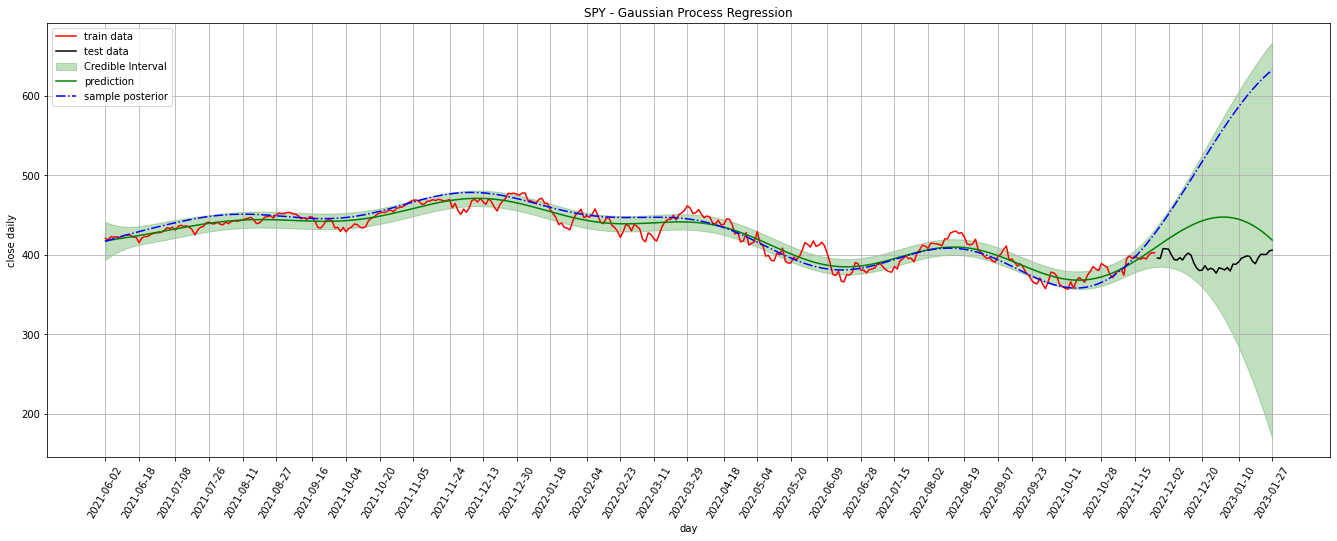

In [6]:
#recall data
data_name = 'close daily'
data = data_dic[data_name]

x = data.index.values
y = data.Close.values

#split data
split_x = int(0.9 * len(x))
x_train,y_train = x[:split_x], y[:split_x]
x_test, y_test = x[split_x:], y[split_x:]

print('Last day on train data:', data.iloc[split_x-1]['Date'].strftime('%Y-%m-%d'),'\n')

#define model parameters
params = {}

kernel_rbf = ConstantKernel(constant_value=3) * RBF(length_scale=1)
sigma_n = 30
n_restarts_optimizer = 100

params['kernel'] = kernel_rbf
params['sigma_n'] = sigma_n
params['n_restarts_optimizer']=n_restarts_optimizer

#train, predict, MSE
y_prediction, std, params_fitted, y_posterior = gaussian_process_regressor(x_train, y_train, x_test, y_test, params)

#plot results
plot(data_name, x_train, y_train, x_test, y_test, y_prediction, std, y_posterior)

Train GPR model using **daily data from 2021-06 to 2022-12** (Same as Above) with "super kernel" to predict SPY price from 2022-12 to 2023-01-27 -- **BEST RESULTS**

Last day on train data: 2022-11-25 

MSE Of Test Set : 251.74957546961798


/home/matheus/python/matheus_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


{'k1': 0.0276**2 * RBF(length_scale=0.0732) + 305**2 * RBF(length_scale=780) * ExpSineSquared(length_scale=22.3, periodicity=84.4) + 0.0157**2 * RationalQuadratic(alpha=1e-05, length_scale=0.0014) + 25.1**2 * RBF(length_scale=83.7),
 'k2': WhiteKernel(noise_level=0.00958),
 'k1__k1': 0.0276**2 * RBF(length_scale=0.0732) + 305**2 * RBF(length_scale=780) * ExpSineSquared(length_scale=22.3, periodicity=84.4) + 0.0157**2 * RationalQuadratic(alpha=1e-05, length_scale=0.0014),
 'k1__k2': 25.1**2 * RBF(length_scale=83.7),
 'k1__k1__k1': 0.0276**2 * RBF(length_scale=0.0732) + 305**2 * RBF(length_scale=780) * ExpSineSquared(length_scale=22.3, periodicity=84.4),
 'k1__k1__k2': 0.0157**2 * RationalQuadratic(alpha=1e-05, length_scale=0.0014),
 'k1__k1__k1__k1': 0.0276**2 * RBF(length_scale=0.0732),
 'k1__k1__k1__k2': 305**2 * RBF(length_scale=780) * ExpSineSquared(length_scale=22.3, periodicity=84.4),
 'k1__k1__k1__k1__k1': 0.0276**2,
 'k1__k1__k1__k1__k2': RBF(length_scale=0.0732),
 'k1__k1__k1__

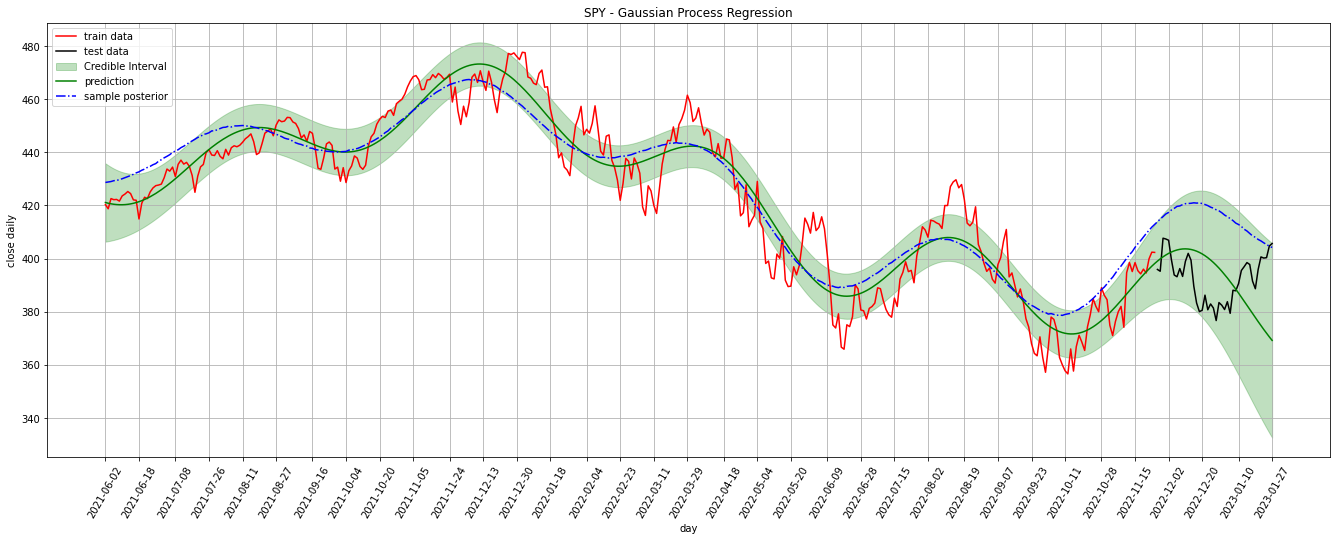

In [7]:
#recall data
data_name = 'close daily'
data = data_dic[data_name]

x = data.index.values
y = data.Close.values

#split data
split_x = int(0.9 * len(x))
x_train,y_train = x[:split_x], y[:split_x]
x_test, y_test = x[split_x:], y[split_x:]

print('Last day on train data:', data.iloc[split_x-1]['Date'].strftime('%Y-%m-%d'),'\n')

#define model parameters
params = {}

super_kernel = 50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) \
                + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
sigma_n = 30
n_restarts_optimizer = 100

params['kernel'] = super_kernel #kernel_rbf
params['sigma_n'] = sigma_n
params['n_restarts_optimizer']=n_restarts_optimizer

#train, predict, MSE
y_prediction, std, params_fitted, y_posterior = gaussian_process_regressor(x_train, y_train, x_test, y_test, params)

#plot results
plot(data_name, x_train, y_train, x_test, y_test, y_prediction, std, y_posterior)

Train GPR model using **average weekly data from 2010-08 to 2021-11** with "super kernel" to predict SPY price from  2021-11 to 2023-01-27

Last day on train data: 2021-10-24 



/home/matheus/python/matheus_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


MSE Of Test Set : 5267.0248878865505


{'k1': 0.00962**2 * RBF(length_scale=0.871) + 316**2 * RBF(length_scale=615) * ExpSineSquared(length_scale=134, periodicity=34.7) + 278**2 * RationalQuadratic(alpha=0.00722, length_scale=464) + 0.00721**2 * RBF(length_scale=3.51e-05),
 'k2': WhiteKernel(noise_level=7.46e-05),
 'k1__k1': 0.00962**2 * RBF(length_scale=0.871) + 316**2 * RBF(length_scale=615) * ExpSineSquared(length_scale=134, periodicity=34.7) + 278**2 * RationalQuadratic(alpha=0.00722, length_scale=464),
 'k1__k2': 0.00721**2 * RBF(length_scale=3.51e-05),
 'k1__k1__k1': 0.00962**2 * RBF(length_scale=0.871) + 316**2 * RBF(length_scale=615) * ExpSineSquared(length_scale=134, periodicity=34.7),
 'k1__k1__k2': 278**2 * RationalQuadratic(alpha=0.00722, length_scale=464),
 'k1__k1__k1__k1': 0.00962**2 * RBF(length_scale=0.871),
 'k1__k1__k1__k2': 316**2 * RBF(length_scale=615) * ExpSineSquared(length_scale=134, periodicity=34.7),
 'k1__k1__k1__k1__k1': 0.00962**2,
 'k1__k1__k1__k1__k2': RBF(length_scale=0.871),
 'k1__k1__k1__k

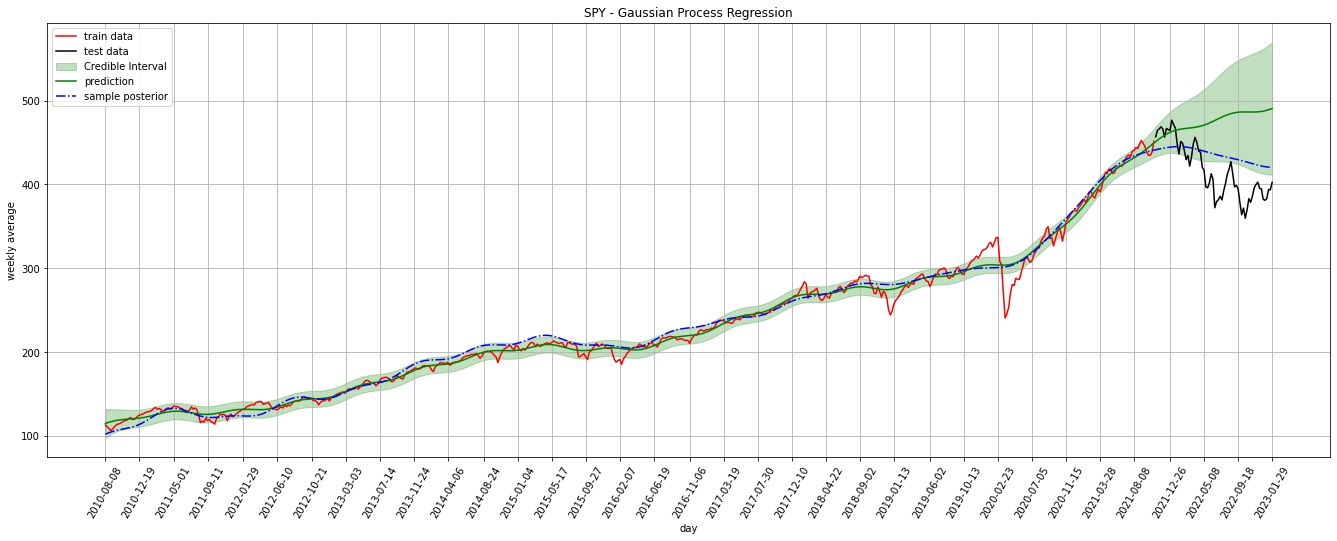

In [8]:
#recall data
data_name = 'weekly average'
data = data_dic[data_name]

x = data.index.values
y = data.Close.values

#split data
split_x = int(0.9 * len(x))
x_train,y_train = x[:split_x], y[:split_x]
x_test, y_test = x[split_x:], y[split_x:]

print('Last day on train data:', data.iloc[split_x-1]['Date'].strftime('%Y-%m-%d'),'\n')

#define model parameters
params = {}
kernel_rbf = ConstantKernel(constant_value=3) * RBF(length_scale=1)
sigma_n = 30
n_restarts_optimizer = 20
super_kernel = 50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) \
                + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

params['kernel'] = super_kernel #kernel_rbf
params['sigma_n'] = sigma_n
params['n_restarts_optimizer']=n_restarts_optimizer

#train, predict, MSE
y_prediction, std, params_fitted, y_posterior = gaussian_process_regressor(x_train, y_train, x_test, y_test, params)

#plot results
plot(data_name, x_train, y_train, x_test, y_test, y_prediction, std, y_posterior)

Train GPR model using **daily percentage move data from 2021-06 to 2022-12** with ExpSineSquared * RBF kernel to predict SPY price from 2022-12 to 2023-01-27

Last day on train data: 2022-11-25 

MSE Of Test Set : 1.429566955727516


{'k1': 1.3**2 * ExpSineSquared(length_scale=0.00363, periodicity=5.74e+04),
 'k2': RBF(length_scale=0.295),
 'k1__k1': 1.3**2,
 'k1__k2': ExpSineSquared(length_scale=0.00363, periodicity=5.74e+04),
 'k1__k1__constant_value': 1.6797519320016718,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__length_scale': 0.0036255706253226993,
 'k1__k2__periodicity': 57390.83574562061,
 'k1__k2__length_scale_bounds': (1e-05, 100000.0),
 'k1__k2__periodicity_bounds': (1e-05, 100000.0),
 'k2__length_scale': 0.29475762371055436,
 'k2__length_scale_bounds': (1e-05, 100000.0)}

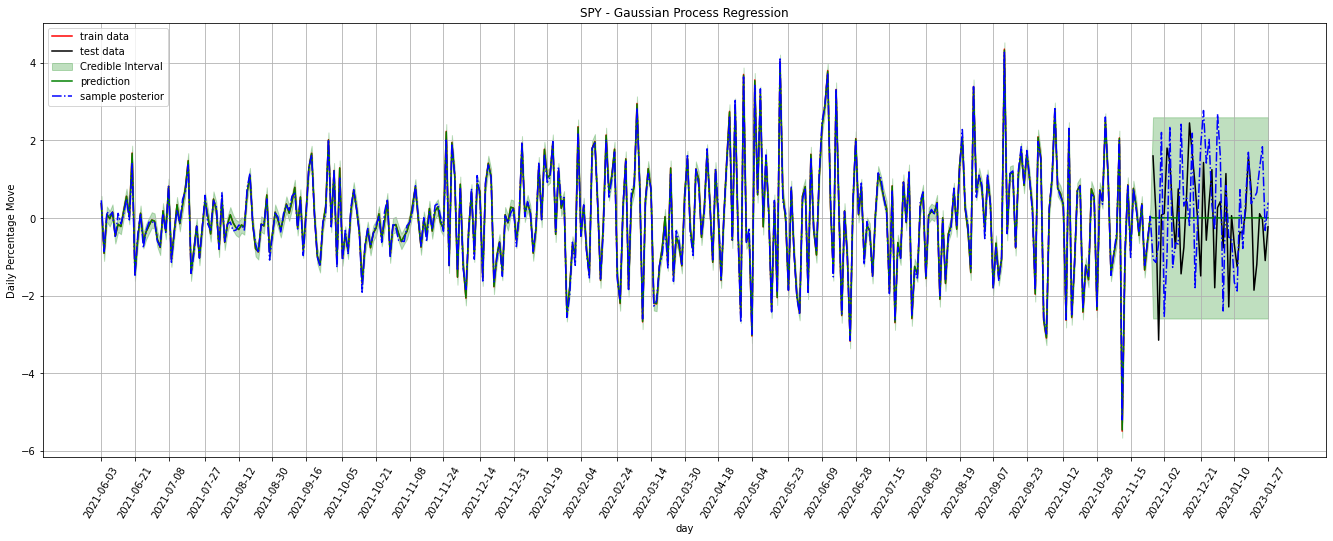

In [9]:
#recall data
data_name = 'Daily Percentage Move'
data = data_dic[data_name]
data

x = data.index.values
y = data.Close_Ratio.values

#split data
split_x = int(0.9 * len(x))
x_train,y_train = x[:split_x], y[:split_x]
x_test, y_test = x[split_x:], y[split_x:]

print('Last day on train data:', data.iloc[split_x-1]['Date'].strftime('%Y-%m-%d'),'\n')

#define model parameters
params = {}

kernel_rbf = ConstantKernel(constant_value=3)  * ExpSineSquared(length_scale=1.44, periodicity=1) *  RBF(length_scale=1)

sigma_n = 0.1
n_restarts_optimizer = 100

params['kernel'] = kernel_rbf
params['sigma_n'] = sigma_n
params['n_restarts_optimizer']=n_restarts_optimizer


#train, predict, MSE
y_prediction, std, params_fitted, y_posterior = gaussian_process_regressor(x_train, y_train, x_test, y_test, params)

#plot results
plot(data_name, x_train, y_train, x_test, y_test, y_prediction, std, y_posterior)

Train GPR model using **normalized data from 2021-06 to 2022-12** with ExpSineSquared * RBF kernel to predict SPY price from 2022-12 to 2023-01-27

/tmp/ipykernel_33084/3963910621.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close2'] = MinMaxScaler().fit_transform(np.array(data['Close']).reshape(-1,1))


Last day on train data: 2022-11-25 



/home/matheus/python/matheus_env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


MSE Of Test Set : 0.09304345542528365


/home/matheus/python/matheus_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matheus/python/matheus_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/matheus/python/matheus_env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better valu

{'k1': 0.00316**2 * RBF(length_scale=0.276) + 0.00316**2 * RBF(length_scale=4.74e+04) * ExpSineSquared(length_scale=0.000648, periodicity=0.0575) + 0.00316**2 * RationalQuadratic(alpha=2.13e+04, length_scale=0.117) + 0.00316**2 * RBF(length_scale=1.77e+04),
 'k2': WhiteKernel(noise_level=1e-05),
 'k1__k1': 0.00316**2 * RBF(length_scale=0.276) + 0.00316**2 * RBF(length_scale=4.74e+04) * ExpSineSquared(length_scale=0.000648, periodicity=0.0575) + 0.00316**2 * RationalQuadratic(alpha=2.13e+04, length_scale=0.117),
 'k1__k2': 0.00316**2 * RBF(length_scale=1.77e+04),
 'k1__k1__k1': 0.00316**2 * RBF(length_scale=0.276) + 0.00316**2 * RBF(length_scale=4.74e+04) * ExpSineSquared(length_scale=0.000648, periodicity=0.0575),
 'k1__k1__k2': 0.00316**2 * RationalQuadratic(alpha=2.13e+04, length_scale=0.117),
 'k1__k1__k1__k1': 0.00316**2 * RBF(length_scale=0.276),
 'k1__k1__k1__k2': 0.00316**2 * RBF(length_scale=4.74e+04) * ExpSineSquared(length_scale=0.000648, periodicity=0.0575),
 'k1__k1__k1__k1

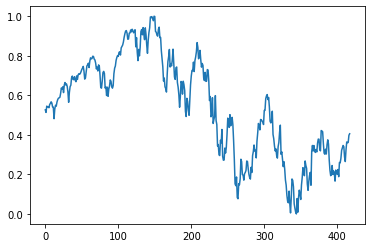

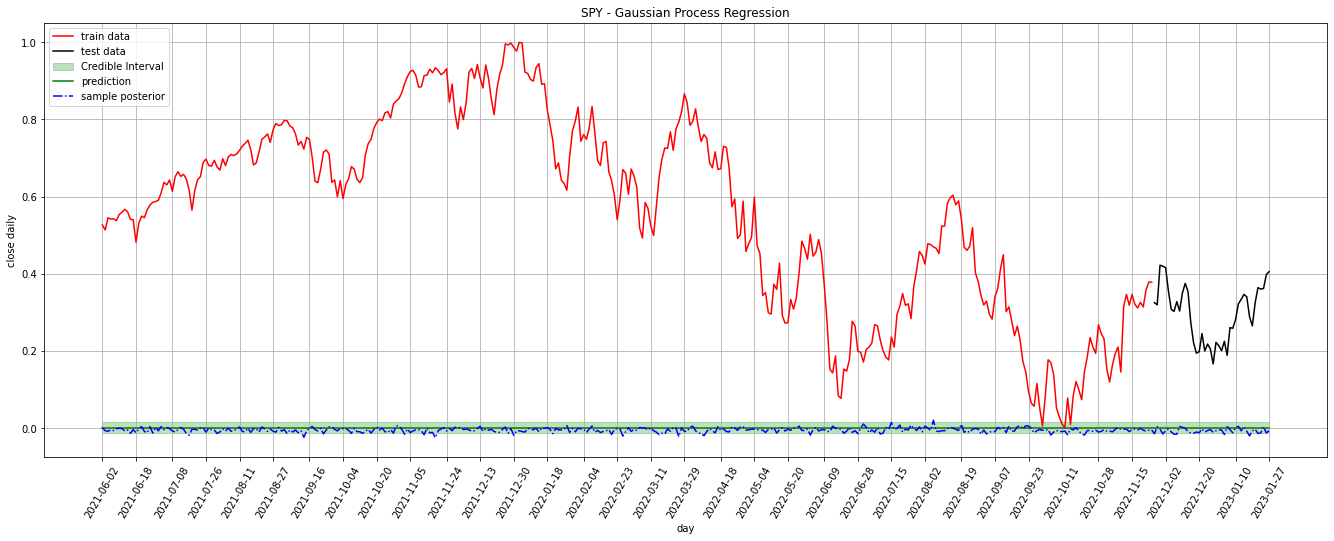

In [10]:
#recall data
data_name = 'close daily'
data = data_dic[data_name]
# display(data)


data['Close2'] = MinMaxScaler().fit_transform(np.array(data['Close']).reshape(-1,1))
data['Close2'].plot()


x = data.index.values
y = data.Close2.values

#split data
split_x = int(0.9 * len(x))
x_train,y_train = x[:split_x], y[:split_x]
x_test, y_test = x[split_x:], y[split_x:]

print('Last day on train data:', data.iloc[split_x-1]['Date'].strftime('%Y-%m-%d'),'\n')

#define model parameters
params = {}

super_kernel = 50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) \
                + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
sigma_n = 30
n_restarts_optimizer = 100


params['kernel'] = super_kernel #kernel_rbf
params['sigma_n'] = sigma_n
params['n_restarts_optimizer']=n_restarts_optimizer

#train, predict, MSE
y_prediction, std, params_fitted, y_posterior = gaussian_process_regressor(x_train, y_train, x_test, y_test, params)

#plot results
plot(data_name, x_train, y_train, x_test, y_test, y_prediction, std, y_posterior)